# 규제가 있는 선형회귀 - 릿지, 라쏘, 엘라스틱넷 회귀

#### 규제가 있는 모델 구축 - 당뇨병 데이터세트
#### 1. 데이터 전처리
#### 2. Ridge, Lasso, Elasticnet regression 구축: 회귀 계수 확인, 하이퍼 파라미터 탐색
#### 3. 교차 검증으로 최적의 하이퍼파라미터 탐색: LassoCV()

In [1]:
# 관련 라이브러리 및 모듈 Import
# import
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import SGDRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
def evaluate_score(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f'mse- {mse:.3f}')
    print(f'rmse- {rmse:.3f}')
    print(f'r2- {r2:.3f}')
    
    return

## 데이터 수집, 탐색, 준비

####  데이터셋에 대한 설명 및 정보 확인

In [4]:
# 데이터 csv 불러오기
train = pd.read_csv('../data/train3.csv')

In [5]:
# Unnamed: 0 column제거
train = train.iloc[:,1:]
# 소수점 2자리까지
train.match = round(train.match, 2)

In [6]:
train.set_index('iid', inplace=True)

In [7]:
# X(독립변수), Y(종속변수) 분할
X = train.drop('match', axis=1)
y = train['match']
# 학습용 데이터와 평가용 데이터로 분할하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 모델별 계수변화, 알파별 계수 비교 데이터프레임(comp_df)

In [8]:
#각 모델별 계수로 이루어진 데이터프레임 준비
comp_df = pd.DataFrame(index=list(X.columns)+['R2_scores'])
comp_df

""
gender
attr3_1
sinc3_1
intel3_1
fun3_1
amb3_1
tmp_att
tmp_sin
tmp_int
tmp_fun


## 각 모델별, 규제강도별 평가지표 저장

####  데이터셋에 대한 설명 및 정보 확인

In [9]:
# 데이터 csv 불러오기
train = pd.read_csv('../data/train3.csv')

In [10]:
# Unnamed: 0 column제거
train = train.iloc[:,1:]
# 소수점 2자리까지
train.match = round(train.match, 2)

In [11]:
train.set_index('iid', inplace=True)

In [12]:
# X(독립변수), Y(종속변수) 분할
X = train.drop('match', axis=1)
y = train['match']
# 학습용 데이터와 평가용 데이터로 분할하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 1. 규제가 없는 선형모델

In [13]:
#모델 구축 및 학습
model_LR = LinearRegression()
model_LR = model_LR.fit(X_train, y_train)

#모델 평가
y_pred = model_LR.predict(X_test)
y_pred[y_pred < 0] = 0.

r2 = r2_score(y_test, y_pred)
print(f"r2= {r2:3f}")
# 회귀 계수 확인
evaluate_score(y_test, y_pred)

# r2
LR_coef = pd.Series(model_LR.coef_, index=X.columns)
print(LR_coef)

r2= 0.165440
mse- 475.137
rmse- 21.798
r2- 0.165
gender        2.488261
attr3_1       0.215311
sinc3_1       1.153511
intel3_1      0.370772
fun3_1        0.296765
amb3_1        0.285441
tmp_att      -0.242308
tmp_sin      -0.507375
tmp_int      -0.160162
tmp_fun       0.071941
tmp_amb      -0.174774
tmp_sha      -0.328281
tmp2_attr     2.563608
tmp2_sinc     0.784270
tmp2_intel   -0.244149
tmp2_fun     -0.644078
tmp2_amb      0.542481
tmp2_shar     3.348662
tmp2_like     1.644996
dtype: float64


- 계수값 시각화

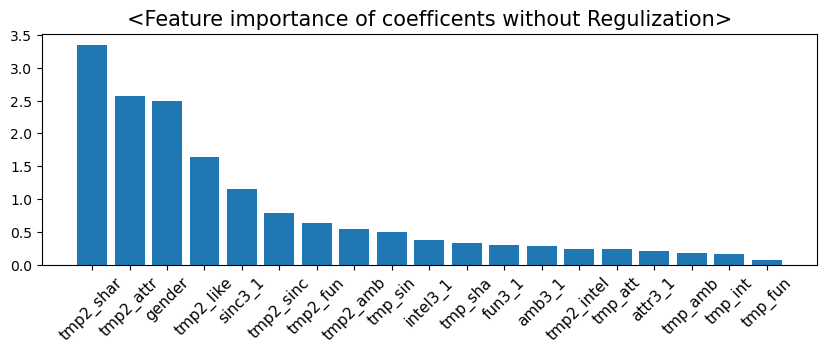

In [14]:
coef = LR_coef.sort_values(ascending=False)
coef = np.abs(LR_coef).sort_values(ascending=False)
# print('======')
# 시각화
plt.figure(figsize=(10,3))
plt.title('<Feature importance of coefficents without Regulization>', fontsize=15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation=45, fontsize=11);

In [15]:
# 모델별 비교 데이터프레임 열 추가
comp_df["LR"] = np.append(model_LR.coef_, r2)
comp_df

,LR
gender,2.488261
attr3_1,0.215311
sinc3_1,1.153511
intel3_1,0.370772
fun3_1,0.296765
amb3_1,0.285441
tmp_att,-0.242308
tmp_sin,-0.507375
tmp_int,-0.160162
tmp_fun,0.071941


In [16]:
# 데이터 csv 불러오기
train = pd.read_csv('../data/train3.csv')

In [17]:
# Unnamed: 0 column제거
train = train.iloc[:,1:]
# 소수점 2자리까지
train.match = round(train.match, 2)

In [18]:
train.set_index('iid', inplace=True)

In [19]:
# X(독립변수), Y(종속변수) 분할
X = train.drop('match', axis=1)
y = train['match']
# 학습용 데이터와 평가용 데이터로 분할하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 1. 릿지 모델

In [20]:
from sklearn.linear_model import Ridge

model_Ridge = Ridge(alpha=1)
model_Ridge.fit(X_train, y_train)

Ridge(alpha=1)

In [21]:
# 릿지 선형회귀 모델 평가: model_Ridge1, alpha=1
y_pred = model_Ridge.predict(X_test)
y_pred[y_pred < 0] = 0.

r2 = r2_score(y_test, y_pred)
print(r2)
# a=1일때 회귀 계수 확인

Ridge_coef = pd.Series(model_Ridge.coef_, index=X.columns)
Ridge_coef

0.16552306031479802


gender        2.441455
attr3_1       0.216246
sinc3_1       1.154184
intel3_1      0.370687
fun3_1        0.293567
amb3_1        0.286159
tmp_att      -0.240782
tmp_sin      -0.506556
tmp_int      -0.159462
tmp_fun       0.073413
tmp_amb      -0.174166
tmp_sha      -0.327049
tmp2_attr     2.554429
tmp2_sinc     0.776725
tmp2_intel   -0.234064
tmp2_fun     -0.631163
tmp2_amb      0.544836
tmp2_shar     3.339819
tmp2_like     1.643094
dtype: float64

- 계수값 시각화

In [22]:
pd.Series(np.abs(Ridge_coef), index=X.columns)

gender        2.441455
attr3_1       0.216246
sinc3_1       1.154184
intel3_1      0.370687
fun3_1        0.293567
amb3_1        0.286159
tmp_att       0.240782
tmp_sin       0.506556
tmp_int       0.159462
tmp_fun       0.073413
tmp_amb       0.174166
tmp_sha       0.327049
tmp2_attr     2.554429
tmp2_sinc     0.776725
tmp2_intel    0.234064
tmp2_fun      0.631163
tmp2_amb      0.544836
tmp2_shar     3.339819
tmp2_like     1.643094
dtype: float64

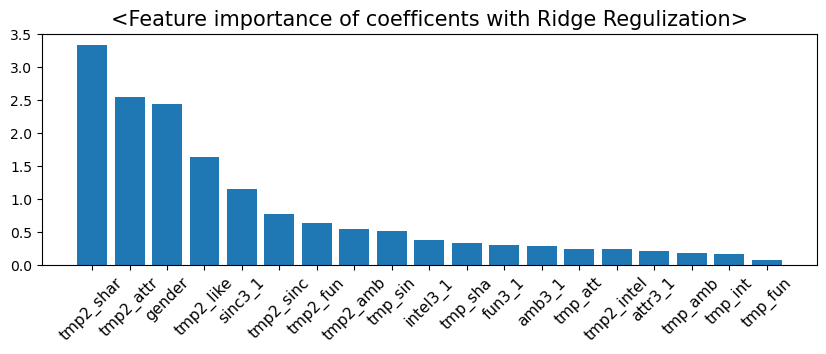

In [23]:
coef = pd.Series(np.abs(Ridge_coef), index=X.columns)
coef = coef.sort_values(ascending=False)
# 시각화
plt.figure(figsize=(10,3))
plt.title('<Feature importance of coefficents with Ridge Regulization>', fontsize=15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation=45, fontsize=11);

In [24]:
# alpha_list=[0.01, 1, 10, 100]인 경우

alpha_list = [0.01, 0.1, 1.5, 10]

for each in alpha_list:
    model_Ridge = Ridge(alpha=each)
    model_Ridge.fit(X_train, y_train)
    
    y_pred = model_Ridge.predict(X_test)
    y_pred[y_pred < 0] = 0.
    
    r2 = r2_score(y_test, y_pred)
    col_name = f'Ridge(alpha={each:.2f})'
    
    comp_df[col_name] = np.append(model_Ridge.coef_, r2)

In [25]:
comp_df

,LR,Ridge(alpha=0.01),Ridge(alpha=0.10),Ridge(alpha=1.50),Ridge(alpha=10.00)
gender,2.488261,2.487784,2.483503,2.418681,2.085686
attr3_1,0.215311,0.215320,0.215404,0.216721,0.225306
sinc3_1,1.153511,1.153518,1.153581,1.154499,1.157888
intel3_1,0.370772,0.370772,0.370766,0.370629,0.368322
fun3_1,0.296765,0.296732,0.296439,0.292018,0.270075
amb3_1,0.285441,0.285448,0.285514,0.286503,0.291042
tmp_att,-0.242308,-0.242293,-0.242154,-0.240036,-0.228901
tmp_sin,-0.507375,-0.507366,-0.507292,-0.506155,-0.500133
tmp_int,-0.160162,-0.160155,-0.160091,-0.159120,-0.153934
tmp_fun,0.071941,0.071956,0.072091,0.074131,0.084868


### 2. 라쏘 모델

In [26]:
from sklearn.linear_model import Lasso

# alpha=1인 경우(default)
model_Lasso = Lasso(alpha=1)
model_Lasso.fit(X_train, y_train)

Lasso(alpha=1)

In [27]:
# 라쏘 선형회귀 모델 평가(alpha=1)
# 선형 모델 평가
y_pred = model_Lasso.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)
#a = 1 라쏘 모델 회귀 계수
Lasso_coef = pd.Series(model_Lasso.coef_, index=X.columns)
Lasso_coef

0.15677600719595242


gender        0.000000
attr3_1       0.049436
sinc3_1       0.853173
intel3_1      0.000000
fun3_1        0.023903
amb3_1        0.196940
tmp_att      -0.001518
tmp_sin      -0.310281
tmp_int       0.000000
tmp_fun       0.266973
tmp_amb      -0.000000
tmp_sha      -0.120024
tmp2_attr     2.250492
tmp2_sinc     0.000000
tmp2_intel    0.000000
tmp2_fun      0.000000
tmp2_amb      0.088884
tmp2_shar     3.331056
tmp2_like     1.097710
dtype: float64

- 계수 시각화

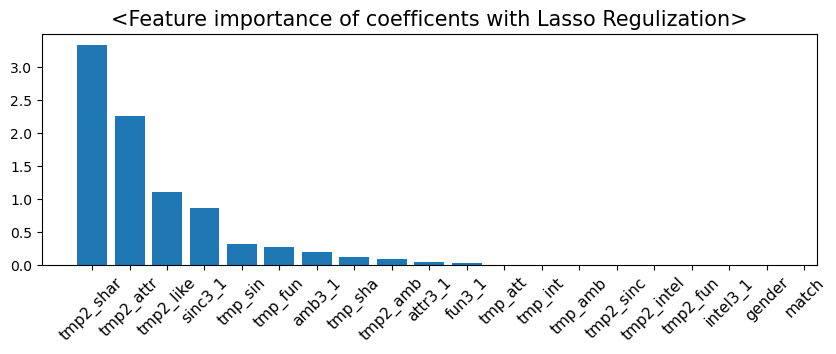

In [28]:
coef = np.abs(Lasso_coef)
coef = pd.Series(coef, index=train.columns).sort_values(ascending=False)
coef
# 시각화
plt.figure(figsize=(10,3))
plt.title('<Feature importance of coefficents with Lasso Regulization>', fontsize=15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation=45, fontsize=11);

In [29]:
# alpha_list=[0.01, 1, 10, 100]인 경우

alpha_list = [0.01, 0.1, 1.5, 10]

for each in alpha_list:
    model_Lasso = Lasso(alpha=each)
    model_Lasso.fit(X_train, y_train)
    
    y_pred = model_Lasso.predict(X_test)
    y_pred[y_pred < 0] = 0.
    
    r2 = r2_score(y_test, y_pred)
    col_name = f'Lasso(alpha={each:.2f})'
    
    comp_df[col_name] = np.append(model_Lasso.coef_, r2)

In [30]:
comp_df

,LR,Ridge(alpha=0.01),Ridge(alpha=0.10),Ridge(alpha=1.50),Ridge(alpha=10.00),Lasso(alpha=0.01),Lasso(alpha=0.10),Lasso(alpha=1.50),Lasso(alpha=10.00)
gender,2.488261,2.487784,2.483503,2.418681,2.085686,2.419806,1.841103,0.000000,0.000000
attr3_1,0.215311,0.215320,0.215404,0.216721,0.225306,0.214496,0.203533,0.000000,0.000000
sinc3_1,1.153511,1.153518,1.153581,1.154499,1.157888,1.157066,1.162699,0.640173,0.000000
intel3_1,0.370772,0.370772,0.370766,0.370629,0.368322,0.364460,0.338368,0.000000,0.000000
fun3_1,0.296765,0.296732,0.296439,0.292018,0.270075,0.291344,0.226675,0.000000,0.000000
amb3_1,0.285441,0.285448,0.285514,0.286503,0.291042,0.287851,0.289314,0.107345,0.000000
tmp_att,-0.242308,-0.242293,-0.242154,-0.240036,-0.228901,-0.235799,-0.182503,-0.000000,0.000000
tmp_sin,-0.507375,-0.507366,-0.507292,-0.506155,-0.500133,-0.501809,-0.456667,-0.301182,-0.280771
tmp_int,-0.160162,-0.160155,-0.160091,-0.159120,-0.153934,-0.155113,-0.112810,-0.000000,-0.000000
tmp_fun,0.071941,0.071956,0.072091,0.074131,0.084868,0.078242,0.128587,0.260434,0.165054


### 3. 엘라스틱넷 모델

In [31]:
from sklearn.linear_model import ElasticNet
# 모델 구축 및 학습(alpha=1, l1_ratio=0.5)

model_ElasticNet = ElasticNet(alpha=0.1, l1_ratio=0.5)
model_ElasticNet.fit(X_train, y_train)

ElasticNet(alpha=0.1)

In [32]:
#모델 평가 및 회귀 계수 확인
# 엘라스틱넷 선형회귀 모델 평가(alpha=1, L1_ratio=0.5)
# 선형 모델 평가
y_pred = model_ElasticNet.predict(X_test)
y_pred[y_pred < 0] = 0.

r2 = r2_score(y_test, y_pred)
print(r2)
evaluate_score(y_test, y_pred)
#a = 1 엘라스틱넷 모델 회귀 계수
ElasticNet_coef = pd.Series(model_ElasticNet.coef_, index=X.columns)

0.1671980115330911
mse- 474.136
rmse- 21.775
r2- 0.167


- 계수 시각화

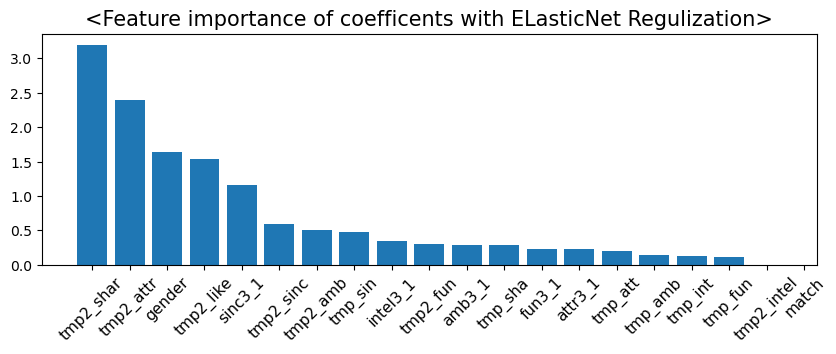

In [33]:
coef = np.abs(ElasticNet_coef)
coef = pd.Series(coef, index=train.columns).sort_values(ascending=False)
coef
# 시각화
plt.figure(figsize=(10,3))
plt.title('<Feature importance of coefficents with ELasticNet Regulization>', fontsize=15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation=45, fontsize=11);

In [34]:
# alpha_list=[0.01, 1, 10, 100]인 경우, l1_ratio=0.5 

alpha_list = [0.01, 0.1, 1.5, 10]

for each in alpha_list:
    model_ElasticNet = ElasticNet(alpha=each)
    model_ElasticNet.fit(X_train, y_train)
    
    y_pred = model_ElasticNet.predict(X_test)
    y_pred[y_pred < 0] = 0.
    
    r2 = r2_score(y_test, y_pred)
    col_name = f'ElasticNet(alpha={each:.2f})'
    
    comp_df[col_name] = np.append(model_ElasticNet.coef_, r2)
comp_df

,LR,Ridge(alpha=0.01),Ridge(alpha=0.10),Ridge(alpha=1.50),Ridge(alpha=10.00),Lasso(alpha=0.01),Lasso(alpha=0.10),Lasso(alpha=1.50),Lasso(alpha=10.00),ElasticNet(alpha=0.01),ElasticNet(alpha=0.10),ElasticNet(alpha=1.50),ElasticNet(alpha=10.00)
gender,2.488261,2.487784,2.483503,2.418681,2.085686,2.419806,1.841103,0.000000,0.000000,2.378503,1.634247,0.000000,0.000000
attr3_1,0.215311,0.215320,0.215404,0.216721,0.225306,0.214496,0.203533,0.000000,0.000000,0.216468,0.227146,0.253024,0.000000
sinc3_1,1.153511,1.153518,1.153581,1.154499,1.157888,1.157066,1.162699,0.640173,0.000000,1.156290,1.160318,0.748322,0.000000
intel3_1,0.370772,0.370772,0.370766,0.370629,0.368322,0.364460,0.338368,0.000000,0.000000,0.367473,0.346495,0.001837,0.000000
fun3_1,0.296765,0.296732,0.296439,0.292018,0.270075,0.291344,0.226675,0.000000,0.000000,0.288905,0.230203,0.177525,0.000000
amb3_1,0.285441,0.285448,0.285514,0.286503,0.291042,0.287851,0.289314,0.107345,0.000000,0.287752,0.293540,0.175811,0.000000
tmp_att,-0.242308,-0.242293,-0.242154,-0.240036,-0.228901,-0.235799,-0.182503,-0.000000,0.000000,-0.236597,-0.194725,-0.015294,0.000000
tmp_sin,-0.507375,-0.507366,-0.507292,-0.506155,-0.500133,-0.501809,-0.456667,-0.301182,-0.280771,-0.503283,-0.472825,-0.332295,-0.303973
tmp_int,-0.160162,-0.160155,-0.160091,-0.159120,-0.153934,-0.155113,-0.112810,-0.000000,-0.000000,-0.156514,-0.128376,-0.000000,-0.000000
tmp_fun,0.071941,0.071956,0.072091,0.074131,0.084868,0.078242,0.128587,0.260434,0.165054,0.077456,0.117250,0.262365,0.216462


# Scaling, GridSerchCV

####  데이터셋에 대한 설명 및 정보 확인

In [35]:
# 데이터 csv 불러오기
train = pd.read_csv('../data/train3.csv')

In [36]:
# Unnamed: 0 column제거
train = train.iloc[:,1:]
# 소수점 2자리까지
train.match = round(train.match, 2)

In [37]:
train.set_index('iid', inplace=True)

In [38]:
# X(독립변수), Y(종속변수) 분할
X = train.drop('match', axis=1)
y = train['match']
# 학습용 데이터와 평가용 데이터로 분할하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 규제가 없는 선형 모델

In [39]:
# 파이프라인 정의
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_regression', LinearRegression())
])

# 탐색할 하이퍼파라미터 값 지정
param_grid = {}

# 그리드 서치 객체 생성
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 모델 선택
best_model = grid_search.best_estimator_

# 최적의 하이퍼파라미터 출력
print("Best Parameters: ", grid_search.best_params_)

# 모델 평가
y_pred = best_model.predict(X_test)
y_pred[y_pred < 0] = 0.

evaluate_score(y_test, y_pred)

Best Parameters:  {}
mse- 475.137
rmse- 21.798
r2- 0.165


In [40]:
# 회귀 계수 확인
LR_coef = pd.Series(best_model.named_steps['linear_regression'].coef_, index=X.columns)
LR_coef

gender        1.244079
attr3_1       0.304411
sinc3_1       1.668592
intel3_1      0.418015
fun3_1        0.457031
amb3_1        0.535900
tmp_att      -2.862511
tmp_sin      -3.797218
tmp_int      -1.135329
tmp_fun       0.475726
tmp_amb      -1.114728
tmp_sha      -2.200314
tmp2_attr     3.402794
tmp2_sinc     0.805681
tmp2_intel   -0.234299
tmp2_fun     -0.810385
tmp2_amb      0.580069
tmp2_shar     4.721616
tmp2_like     2.035413
dtype: float64

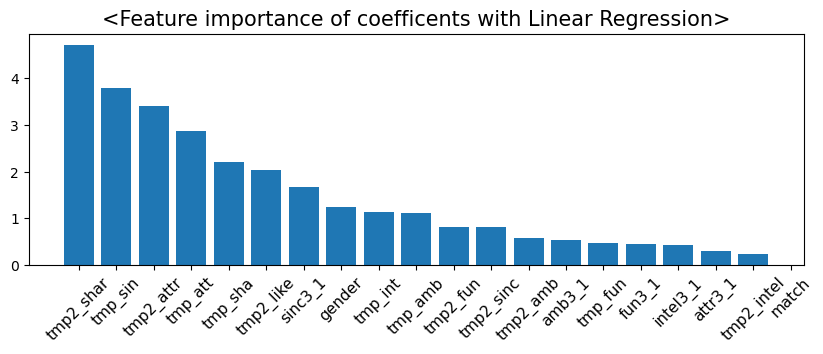

In [41]:
coef = np.abs(LR_coef)
coef = pd.Series(coef, index=train.columns).sort_values(ascending=False)
coef
# 시각화
plt.figure(figsize=(10,3))
plt.title('<Feature importance of coefficents with Linear Regression>', fontsize=15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation=45, fontsize=11);

### 릿지 모델 scaling, GridSerchCV

In [42]:
# 파이프라인 정의
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# 탐색할 하이퍼파라미터 값 지정
param_grid = {
    'ridge__alpha': [0.01, 0.1, 1, 10, 125]
}

# 그리드 서치 객체 생성
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 모델 선택
best_model = grid_search.best_estimator_

# 최적의 하이퍼파라미터 출력
print("Best Parameters: ", grid_search.best_params_)

# 릿지 선형회귀 모델 평가
y_pred = best_model.predict(X_test)
y_pred[y_pred < 0] = 0.

evaluate_score(y_test, y_pred)

Best Parameters:  {'ridge__alpha': 125}
mse- 466.695
rmse- 21.603
r2- 0.180


In [43]:
# 릿지모델 회귀 계수
ridge_coef = pd.Series(best_model.named_steps['ridge'].coef_, index=X.columns)
ridge_coef

gender        0.620075
attr3_1       0.596216
sinc3_1       1.166149
intel3_1      0.338193
fun3_1        0.547402
amb3_1        0.520311
tmp_att      -0.062035
tmp_sin      -1.654227
tmp_int       0.196175
tmp_fun       1.499164
tmp_amb       0.062913
tmp_sha      -0.597948
tmp2_attr     2.493181
tmp2_sinc     0.594529
tmp2_intel    0.169489
tmp2_fun      0.503484
tmp2_amb      0.685177
tmp2_shar     3.119389
tmp2_like     1.966726
dtype: float64

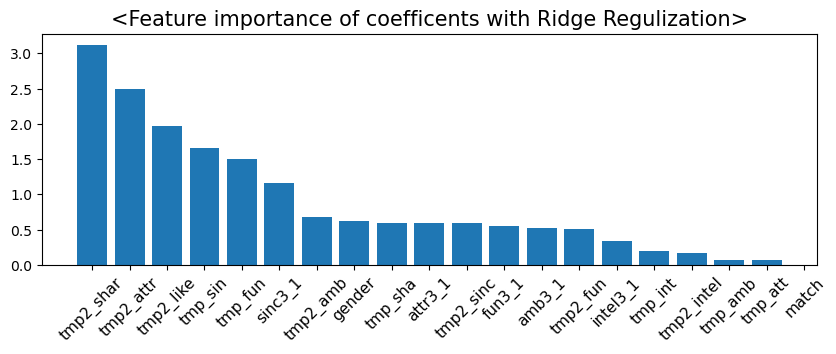

In [44]:
coef = np.abs(ridge_coef)
coef = pd.Series(coef, index=train.columns).sort_values(ascending=False)
coef
# 시각화
plt.figure(figsize=(10,3))
plt.title('<Feature importance of coefficents with Ridge Regulization>', fontsize=15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation=45, fontsize=11);

#### 예측값

In [45]:
y_pred

array([18.5217421 , 13.73970287, 15.98902636, 32.75827037, 11.98764401,
       38.18448306, 20.80517784, 21.80175472, 31.84899718, 27.48232343,
        7.01737541, 11.31945531, 27.83957038, 22.29352331, 19.36349938,
        8.10558352,  0.        , 25.73073227, 22.65620137, 12.57542273,
       16.79952937, 43.8311671 , 27.49932271, 11.0603332 , 19.8053177 ,
       20.33119828, 46.9802223 , 14.63188642, 21.39368331, 20.52725653,
       13.68310847, 37.52582901, 26.87206014, 23.20333166, 22.60182263,
        9.0886002 , 10.6600054 , 27.75825268, 22.38616537,  9.93387405,
       31.00235772,  8.45219469,  9.81262263, 26.97753302, 34.53378259,
       14.01474238,  3.34318366, 16.54968341, 21.49434758, 26.86969967,
       17.11356624, 21.50457913, 14.15658527, 28.15969093,  5.86616401,
       20.58180691, 17.71204848, 17.80203125, 22.62961343,  0.93426904,
       19.71189578, 20.27642589, 14.14778278, 11.25184111, 23.41658528,
       30.19381501, 24.91566645,  9.76394705, 31.56232609, 19.63

### 라쏘 모델 scaling, GridSerchCV

In [46]:
# 데이터 로드
X = train.drop('match', axis=1)
y = train['match']
# 학습용 데이터와 평가용 데이터로 분할하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 파이프라인 정의
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso())
])

# 탐색할 하이퍼파라미터 값 지정
param_grid = {
    'lasso__alpha': [0.001, 0.01, 0.1, 1.5, 10, 100]
}

# 그리드 서치 객체 생성
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 모델 선택
best_model = grid_search.best_estimator_

# 최적의 하이퍼파라미터 출력
print("Best Parameters: ", grid_search.best_params_)

# 예측
y_pred = best_model.predict(X_test)
y_pred[y_pred < 0] = 0.
# 모델 성능 평가
evaluate_score(y_test, y_pred)

Best Parameters:  {'lasso__alpha': 1.5}
mse- 468.075
rmse- 21.635
r2- 0.178


In [47]:
#라쏘 모델 회귀 계수
Lasso_coef = pd.Series(best_model.named_steps['lasso'].coef_, index=X.columns)
Lasso_coef

gender        0.000000
attr3_1       0.000000
sinc3_1       0.000000
intel3_1      0.000000
fun3_1        0.234856
amb3_1        0.000000
tmp_att       0.000000
tmp_sin      -0.899348
tmp_int      -0.000000
tmp_fun       0.795613
tmp_amb      -0.000000
tmp_sha      -0.000000
tmp2_attr     3.386943
tmp2_sinc     0.000000
tmp2_intel    0.000000
tmp2_fun      0.000000
tmp2_amb      0.000000
tmp2_shar     4.224028
tmp2_like     1.051705
dtype: float64

- 계수 시각화

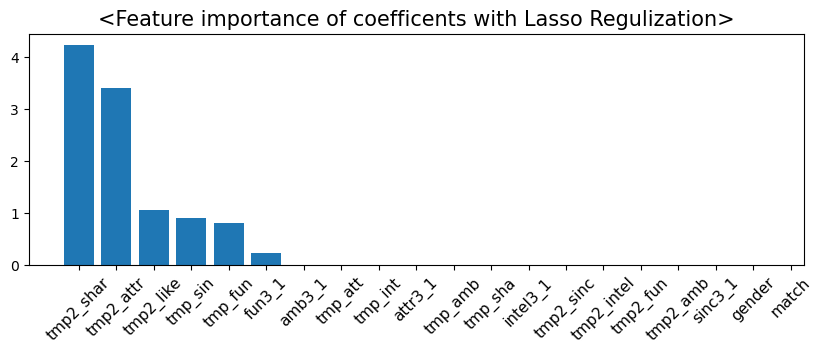

In [48]:
coef = np.abs(Lasso_coef)
coef = pd.Series(coef, index=train.columns).sort_values(ascending=False)
coef
# 시각화
plt.figure(figsize=(10,3))
plt.title('<Feature importance of coefficents with Lasso Regulization>', fontsize=15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation=45, fontsize=11);

#### 예측값

In [49]:
y_pred

array([17.04999563, 14.03891218, 14.24741939, 30.1504801 , 15.77274854,
       39.00017574, 16.75278605, 21.29042567, 28.31064513, 25.02491484,
       11.34113949,  9.8347645 , 30.25440089, 16.67484427, 20.58001568,
        7.57578204,  0.        , 23.71532823, 22.37629714, 11.16301542,
       19.06440735, 43.65590106, 27.18685864, 13.13230227, 23.13758747,
       20.52859556, 42.76988038, 16.05483542, 19.58075787, 19.17550864,
        8.15107062, 31.43390614, 27.06927508, 22.75036898, 22.76140682,
        7.61151964, 13.37210015, 27.91197065, 21.6502259 ,  8.7505469 ,
       26.61821852,  9.21342802, 12.42725198, 25.18506569, 28.97175794,
       16.09056335,  4.38283656, 17.68022262, 20.85340736, 28.55813411,
       17.4994513 , 23.62192495, 16.17578911, 28.06486746,  6.27627997,
       22.01512503, 20.38511652, 19.47544738, 20.22499134,  1.17543796,
       21.49717366, 17.05518621, 15.93126598, 15.5192302 , 24.4872206 ,
       27.42100168, 21.93580158, 10.77899307, 31.81827259, 19.18

### SGDRegressor의 엘라스틱넷규제 모델 scaling, GridSerchCV

In [50]:
# 데이터셋을 훈련용과 테스트용으로 분리
X = train.drop('match', axis=1)
y = train['match']
# 학습용 데이터와 평가용 데이터로 분할하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 모델 파이프라인 생성
model = make_pipeline(
    StandardScaler(),
    SGDRegressor(loss='squared_error', penalty='elasticnet', random_state=42)
)

# GridSearchCV를 사용하여 하이퍼파라미터 튜닝
param_grid = {
    'sgdregressor__alpha': [0.001, 0.01, 0.1, 1.5, 10, 100],
    'sgdregressor__l1_ratio': [0.05, 0.1, 0.15, 0.5, 0.75, 0.9],
    'sgdregressor__max_iter': [100],
}

# 그리드 서치 객체 생성
grid = GridSearchCV(model, param_grid, cv=5)

# 모델 학습
grid.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best parameters: ", grid.best_params_)

# 최적의 모델 선택
best_model = grid.best_estimator_

# 예측
y_pred = best_model.predict(X_test)
y_pred[y_pred < 0] = 0.

# 최적의 모델로 성능 평가
evaluate_score(y_test, y_pred)

Best parameters:  {'sgdregressor__alpha': 1.5, 'sgdregressor__l1_ratio': 0.15, 'sgdregressor__max_iter': 100}
mse- 459.271
rmse- 21.431
r2- 0.193


In [51]:
#모델 회귀 계수
ElasticNet_coef = pd.Series(best_model.named_steps['sgdregressor'].coef_, index=X.columns)
ElasticNet_coef

gender        0.162995
attr3_1       0.664603
sinc3_1       0.562571
intel3_1      0.326720
fun3_1        0.654347
amb3_1        0.384329
tmp_att       0.000000
tmp_sin      -1.031329
tmp_int       0.000000
tmp_fun       1.032463
tmp_amb       0.000000
tmp_sha      -0.402706
tmp2_attr     1.914232
tmp2_sinc     0.708253
tmp2_intel    0.465761
tmp2_fun      1.072300
tmp2_amb      0.895063
tmp2_shar     2.226682
tmp2_like     1.805901
dtype: float64

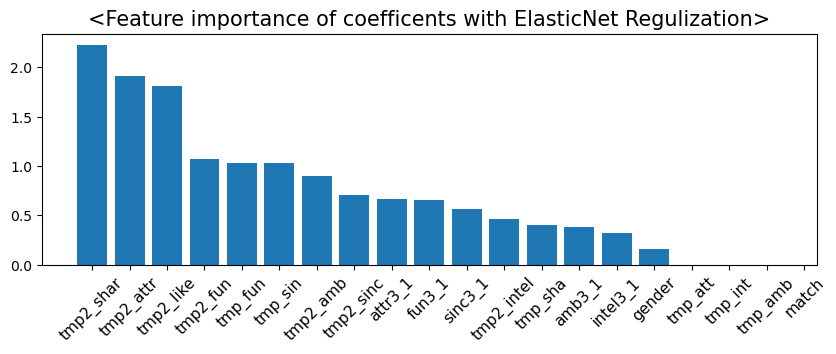

In [52]:
coef = np.abs(ElasticNet_coef)
coef = pd.Series(coef, index=train.columns).sort_values(ascending=False)
coef
# 시각화
plt.figure(figsize=(10,3))
plt.title('<Feature importance of coefficents with ElasticNet Regulization>', fontsize=15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation=45, fontsize=11);

#### 예측값

In [53]:
y_pred = grid.predict(X_test)
y_pred[y_pred < 0] = 0.

print("Predictions: ", y_pred)

Predictions:  [18.42849761 14.07748178 15.54964443 30.62834033 12.92037093 40.32695235
 20.92423803 21.60564399 30.88836918 25.48080735  8.47289561 11.36383956
 28.48841525 22.31775842 20.2214452   7.9734803   0.         24.43709862
 21.7239265  12.05133343 17.30309964 43.32613334 26.84192444 12.32074271
 18.67819787 19.74618424 46.43743626 13.69398753 20.83129655 20.33565901
 14.31415079 35.71919961 26.06643809 23.16134432 21.55515066 11.05750302
 12.20611833 27.00256784 22.35029618  9.72020887 28.75188101  9.14780437
  9.36262132 26.36615565 32.88666222 15.24714751  5.67452495 18.47261418
 21.00911096 27.12601347 17.6356613  20.02804667 14.59214292 27.57745148
  6.44984804 20.38609714 17.74399131 18.11469496 22.11266136  2.86521778
 20.07757866 19.32072574 15.40285561 13.12698539 21.95536428 29.32943345
 23.19362537  9.59376661 30.26758283 19.42836837 15.00247021 18.78973426
 16.15526574 14.38556799 12.81885259 23.12162233 22.13314157 14.34704441
 28.87576782 11.18462667 20.26203618 